In [1]:
import math, os
import pydicom
import numpy as np
import pandas as pd
from utils import display
from scipy import ndimage
import matplotlib.pyplot as plt

- crop edge out : some wrong value
- find MTF bar

In [2]:
# by col
def find_edge_col(arr) :
    # Return width min to max
    nrows, ncols = arr.shape
    none_count = 0
    appended = False
    none_ts = 10
    start_none_count = 0
    start_val = arr[int(nrows*.2)][int(ncols*.2)]
    edges_pos = []
    for c in range(ncols) :
        is_c = None
        for r in range(nrows) :
            val = arr[r][c]
            if val != start_val :
                edges_pos.append(c)
                is_c = True
                appended = True # append number already
                none_count = 0
                break
        if not is_c :
            none_count += 1
            start_none_count += 1
            edges_pos.append(0) 
            if none_count >= none_ts and appended :
                break
    w_min, w_max = edges_pos[start_none_count+1-none_ts], edges_pos[-none_ts-1]
    # check is correct
    if w_max-w_min < int(0.15*ncols) :
        w_crop = w_max-w_min+5 # prevent it's equalt = 0
        w_min, w_max = find_edge_col(arr[:, w_crop:])
        w_min, w_max = w_min + w_crop, w_max + w_crop
    return w_min, w_max

In [3]:
# by row
def find_edge_row(arr) :
    # Return width min to max
    nrows, ncols = arr.shape
    none_count = 0
    appended = False
    none_ts = 10
    start_none_count = 0
    start_val = arr[int(nrows*.2)][int(ncols*.2)]
    edges_pos = []
    for r in range(nrows) :
        is_r = None
        for c in range(ncols) :
            val = arr[r][c]
            if val != start_val :
                edges_pos.append(r)
                is_r = True
                appended = True # append number already
                none_count = 0
                break
        if not is_r :
            none_count += 1
            start_none_count += 1
            edges_pos.append(0) 
            if none_count >= none_ts and appended :
                break
    h_min, h_max = edges_pos[start_none_count+1-none_ts], edges_pos[-none_ts-1]
    # check is correct
    if h_max-h_min < int(0.15*nrows) :
        h_crop = h_max-h_min+5 # prevent it's equalt = 0
        h_min, h_max, start_val = find_edge_row(arr[h_crop:, :])
        h_min, h_max = h_min + h_crop, h_max + h_crop
    return h_min, h_max, start_val

In [4]:
# dicom_data = pydicom.dcmread("images/DICOMOBJ/BAR2")
dicom_data = pydicom.dcmread("BAR_eval/SW2/BAR3")
arr = dicom_data.pixel_array
h, w = arr.shape
# assume crop if size > 2,000 (not crop yet)
p = 0.24
if (h*w) > (2000**2) :
    arr = arr[int(h*p): int(h*(1-p)), int(w*p): int(w*(1-p))]

ecrop = [int(0.05*h), int(0.95*h), int(0.05*w), int(0.95*w)]
arr = arr[ecrop[0]: ecrop[1], ecrop[2]: ecrop[3]]
h, w = arr.shape
# find MTF bar
p = 0.33
p_mean = np.mean(arr[int(h*p): int(h*(1-p)), int(w*p): int(w*(1-p))])
parr = np.where(arr>p_mean, 1, 0)
# width finding
vc = [int(h*0.1), int(h/2)]
varr = parr[vc[0]: vc[1]]
w_min, w_max = find_edge_col(varr)
# height finding
hc = [int(w*0.1), int(w/2)]
harr = parr[:, hc[0]: hc[1]]
h_min, h_max, start_val = find_edge_row(harr)
# processing crop, inv, rotate to horizontal
need_inv = start_val == 1
l1, l2 = h_max-h_min, w_max-w_min
need_rotate = l1 > l2 
add_crop = int(0.1*l1) if l1>l2 else int(0.1*l2)
h_min, h_max = max(0, h_min-add_crop), h_max+add_crop # prevent negative 
w_min, w_max = max(0, w_min-add_crop), w_max+add_crop
arr = arr[h_min: h_max, w_min: w_max]
h, w = arr.shape
if need_inv :
    max_val = arr.max()
    arr = max_val-arr
if need_rotate :
    arr = ndimage.rotate(arr, 90)
    h, w = arr.shape

In [5]:
arr.shape, need_inv

((414, 881), True)

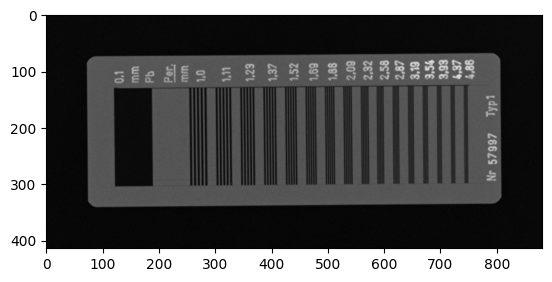

In [6]:
# arr = ndimage.rotate(arr, 180)
display(arr, True)

In [7]:
h, w

(414, 881)

In [8]:
hp = int(0.28*h)
wp = int(0.03*w)

### FOCUS

In [9]:
focus_l = arr[h-2*hp: int(h*.95), wp*9: wp*11]
nrows, ncols = focus_l.shape
nrows, ncols

(209, 52)

In [10]:
def argdiffs(arr) :
    """ 
    find most differents position of pixel value by col
    Return: argdiff in len(col)
    """
    nrows, ncols = arr.shape
    arg_diffs = []
    for c in range(ncols) :
        max_diff = 0
        argmax_diff = 0
        for r in range(nrows) :
            # find different of past val 
            if r+1 < nrows : # index out of length
                cur_val = arr[r][c]
                next_val = arr[r+1][c]
                diff = abs(int(cur_val) - int(next_val)) # overflow
                if diff > max_diff :
                    max_diff = diff
                    argmax_diff = r
        arg_diffs.append(argmax_diff)
    return arg_diffs

In [11]:
arg_diffs = argdiffs(focus_l)
len(arg_diffs)

52

In [12]:
unique_elements, counts = np.unique(arg_diffs, return_counts=True)
unique_elements, counts

(array([119, 155]), array([ 1, 51], dtype=int64))

In [13]:
# most common argdiff
arg_diffs = argdiffs(focus_l)
unique_elements, counts = np.unique(arg_diffs, return_counts=True)
most_common_index = np.argmax(counts)
y1 = unique_elements[most_common_index]
y1

155

In [14]:
focus_r = arr[h-2*hp: int(h*.95), w-(wp*11): w-(wp*9)]
nrows, ncols = focus_r.shape
nrows, ncols

(209, 52)

In [15]:
# most common argdiff
arg_diffs = argdiffs(focus_r)
unique_elements, counts = np.unique(arg_diffs, return_counts=True)
most_common_index = np.argmax(counts)
y2 = unique_elements[most_common_index]
y2

152

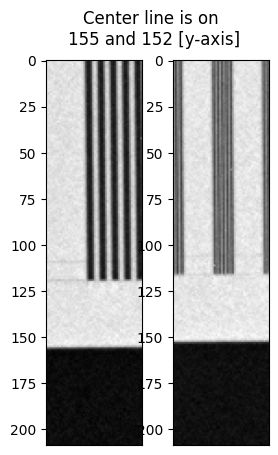

In [16]:
plt.figure(figsize=(3, 5))
plt.subplot(1, 2, 1)
display(focus_l, axis=True)
plt.tick_params(bottom=False, labelbottom=False) # hide x-axis

plt.subplot(1, 2, 2)
display(focus_r, axis=True)
plt.tick_params(bottom=False, labelbottom=False)
plt.suptitle(f"Center line is on \n{y1} and {y2} [y-axis]");

In [17]:
def find_theta(w, y1, y2) :
    """
    find theta from y1, y2
    Return: theta in degree
    """
    a = y2-y1
    theta_r = math.atan(a/w)
    print(theta_r)
    theta_d = math.degrees(theta_r)
    return theta_d

In [18]:
y2, y1

(152, 155)

In [19]:
theta = find_theta(w, y1, y2)
theta

-0.003405208177693874


-0.19510405694529304

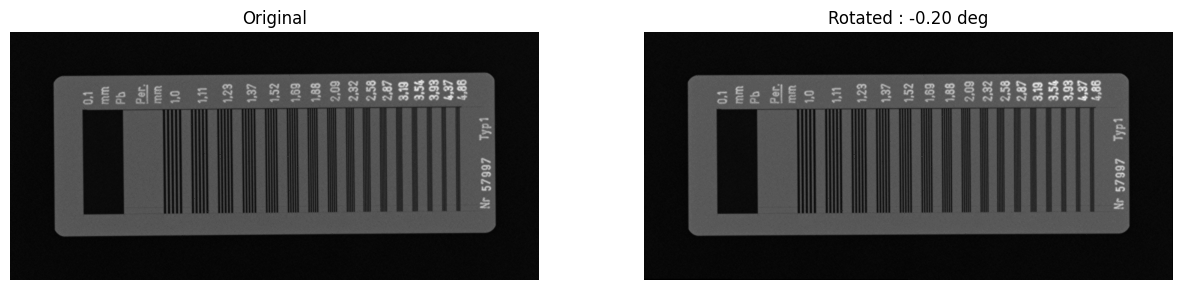

In [20]:
if theta > 3 :
    # wrong direction
    arr = ndimage.rotate(arr, 180)

rotate_img = ndimage.rotate(arr, theta, reshape=False, cval=arr.min())

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Original")
display(arr)

plt.subplot(1, 2, 2)
plt.title(f"Rotated : {theta:.2f} deg")
display(rotate_img)

In [21]:
h, w = rotate_img.shape
h, w

(414, 881)

In [22]:
hp = int(0.11*h)
wp = int(0.10*w)

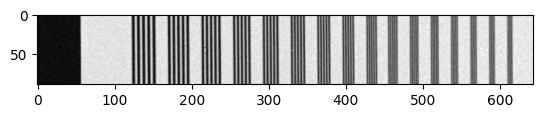

In [23]:
focus = rotate_img[h//2-hp: h//2+hp, int(wp*1.5): w-int(wp*1.2)]
display(focus, True)

In [24]:
focus.shape

(90, 644)

In [25]:
rotate_check = focus[:, :int(wp/3)]
std = np.std(rotate_check)
print(std)
if std > (focus.max() - focus.min())/30 :
    rotate_img = ndimage.rotate(rotate_img, 180)
    focus = rotate_img[h//2-hp: h//2+hp, int(wp*1.5): w-int(wp*1.2)]
    display(focus, True)

8.260820906537186


In [26]:
focus.shape

(90, 644)

In [27]:
# mean by col
oneline_ori = np.mean(focus, axis=0, dtype=np.uint32)
p_mean = np.mean(oneline_ori)
oneline = np.where(oneline_ori > p_mean, 1, 0)
s = np.vstack((oneline, oneline, oneline, oneline, oneline, oneline, oneline, oneline, oneline))
display(s)

In [28]:
space_ts = int(0.02*len(oneline))
positions = []
is_start = True
start_val = None
none_count = 0 # for not lp
for idx, val in enumerate(oneline) :
    if idx+1 == len(oneline) and len(positions) != 17 : # forgot last one
            positions.append((start_val, idx-space_ts))
    # just first lp
    if len(positions) == 0 :
        if val == 1 :
            positions.append((0, idx))
    else :
        if is_start :
            if val == 0 :
                is_start = False
                start_val = idx
        else :
            if val == 1 :
                none_count += 1
                if none_count > space_ts :
                    positions.append((start_val, idx-space_ts)) # back to correct point
                    is_start = True
                    none_count = 0
            else :
                none_count = 0

In [29]:
positions, len(positions)

([(0, 57),
  (123, 154),
  (170, 198),
  (214, 239),
  (255, 277),
  (293, 314),
  (330, 348),
  (364, 381),
  (397, 412),
  (428, 441),
  (456, 468),
  (484, 495),
  (511, 522),
  (538, 547),
  (563, 571),
  (587, 595),
  (611, 617)],
 17)

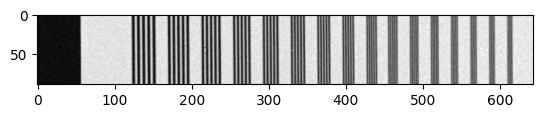

In [30]:
plt.subplot(2, 1, 1)
display(focus, True)

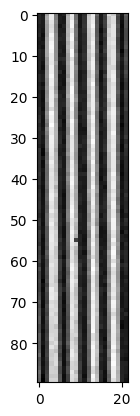

In [31]:
lp = 4
display(focus[:, positions[lp][0]: positions[lp][1]], True)

In [32]:
linepairs = []
for idx in range(len(positions)) :
    if idx < 9 :
        trim = int(0.0028*len(oneline))
    else :
        trim = int(0.004*len(oneline))
    s1, s2 = positions[idx][0]+trim, positions[idx][1]-trim
    if s2 > s1 : 
        linepairs.append((s1, s2))
    else :
        linepairs.append((s1+1, s1+2))
linepairs

[(1, 56),
 (124, 153),
 (171, 197),
 (215, 238),
 (256, 276),
 (294, 313),
 (331, 347),
 (365, 380),
 (398, 411),
 (430, 439),
 (458, 466),
 (486, 493),
 (513, 520),
 (540, 545),
 (565, 569),
 (589, 593),
 (613, 615)]

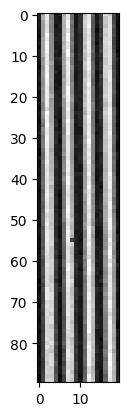

In [33]:
linepair_idx = 4
display(focus[:, linepairs[linepair_idx][0]: linepairs[linepair_idx][1]], True)

In [34]:
focus.shape, linepairs, oneline_ori.shape, arr.shape

((90, 644),
 [(1, 56),
  (124, 153),
  (171, 197),
  (215, 238),
  (256, 276),
  (294, 313),
  (331, 347),
  (365, 380),
  (398, 411),
  (430, 439),
  (458, 466),
  (486, 493),
  (513, 520),
  (540, 545),
  (565, 569),
  (589, 593),
  (613, 615)],
 (644,),
 (414, 881))

In [35]:
min_val0 = np.min(np.mean(focus[:, linepairs[0][0]: linepairs[0][1]], axis=0))
max_val0 = np.max(np.mean(focus[:, linepairs[0][1]: linepairs[1][0]], axis=0))
max_contrast = max_val0 - min_val0
min_val0, max_val0, max_contrast

(60.18888888888889, 510.18888888888887, 450.0)

In [36]:
res = {"Linepair": [0], "Max": [max_val0], "Min": [min_val0], "Contrast": [max_contrast], "Modulation": [100]}
for idx, (s1, s2) in enumerate(linepairs[1:], start=1) :
    linepair = focus[:, s1: s2]
    mean_val_col = np.mean(linepair, axis=0)
    sorted_val = np.sort(mean_val_col) # to seperate max and min vals
    if idx < 7 :
        w = 0.2
    else :
        w = 0.3
    mid_pos = max(min((s2-s1)//2, int(w*(s2-s1))), 1) # how to select actual value, 1 if 0
    mean_min_vals = round(np.mean(sorted_val[: mid_pos]))
    mean_max_vals = round(np.mean(sorted_val[-mid_pos: ]))
    min_vals = np.min(mean_min_vals)
    max_vals = np.max(mean_max_vals)
    # min_vals = np.min(mean_val_col)
    # max_vals = np.max(mean_val_col)
    contrast = max_vals-min_vals
    res["Linepair"].append(idx)
    res["Max"].append(max_vals)
    res["Min"].append(min_vals)
    res["Contrast"].append(contrast)
    res["Modulation"].append(round(contrast*100/max_contrast, 3))
res = pd.DataFrame(res)

In [37]:
linepairs

[(1, 56),
 (124, 153),
 (171, 197),
 (215, 238),
 (256, 276),
 (294, 313),
 (331, 347),
 (365, 380),
 (398, 411),
 (430, 439),
 (458, 466),
 (486, 493),
 (513, 520),
 (540, 545),
 (565, 569),
 (589, 593),
 (613, 615)]

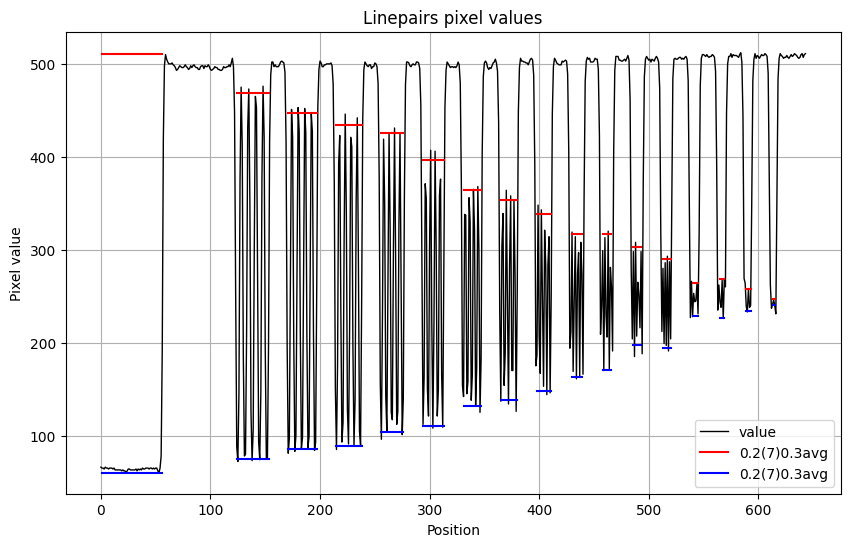

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(oneline_ori, color="black", linewidth=1)
for (s1, s2), (_, max_v, min_v, _, _) in zip(linepairs, res.values) :
    plt.plot([s1, s2], [max_v, max_v], color="red")
    plt.plot([s1, s2], [min_v, min_v], color="blue")
plt.legend(["value", "0.2(7)0.3avg", "0.2(7)0.3avg"])
plt.grid(True)
plt.title("Linepairs pixel values")
plt.ylabel("Pixel value")
plt.xlabel("Position");

In [39]:
res

,Linepair,Max,Min,Contrast,Modulation
0,0,510.188889,60.188889,450.0,100.000
1,1,469.000000,75.000000,394.0,87.556
2,2,447.000000,85.000000,362.0,80.444
3,3,434.000000,89.000000,345.0,76.667
4,4,426.000000,104.000000,322.0,71.556
5,5,397.000000,110.000000,287.0,63.778
6,6,364.000000,132.000000,232.0,51.556
7,7,354.000000,138.000000,216.0,48.000
8,8,338.000000,148.000000,190.0,42.222
9,9,317.000000,163.000000,154.0,34.222


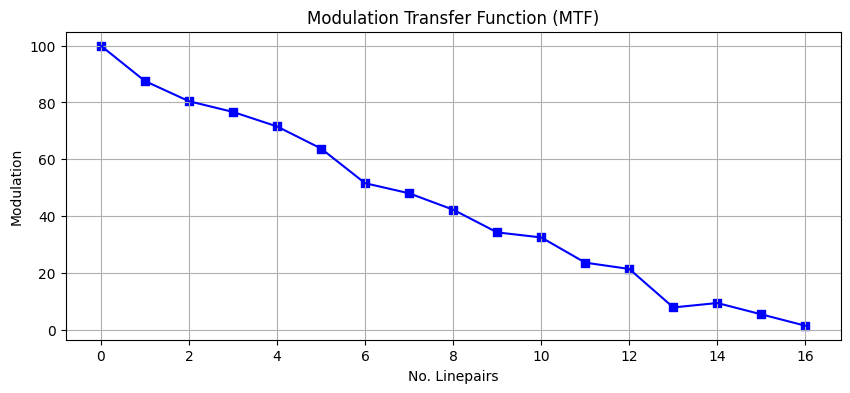

In [40]:
plt.figure(figsize=(10, 4))
plt.title("Modulation Transfer Function (MTF)")
plt.plot(res["Linepair"], res["Modulation"], color="blue")
plt.scatter(res["Linepair"], res["Modulation"], color="blue", marker="s")
plt.grid(True)
plt.ylabel("Modulation")
plt.xlabel("No. Linepairs");